In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
btc_df = pd.read_csv(
    "../data/processed/btc_sentiment_aligned.csv",
    parse_dates=["date"]
)

btc_df = btc_df.sort_values("date").reset_index(drop=True)
btc_df.head()

,date,close,volume,return,asset,finbert_score,vader_score,finbert_lag_1,vader_lag_1,finbert_lag_2,vader_lag_2,finbert_lag_3,vader_lag_3,finbert_lag_5,vader_lag_5
0,2024-10-08,62131.968750,28134475157,-0.001684,BTC,0.380054,0.039746,0.610018,-0.254433,0.768489,0.083333,0.666548,0.220475,0.639643,0.220693
1,2024-10-09,60582.101562,27670982363,-0.025261,BTC,0.263143,0.001271,0.380054,0.039746,0.610018,-0.254433,0.768489,0.083333,0.482686,-0.075309
2,2024-10-10,60274.500000,30452813570,-0.005090,BTC,0.414146,-0.015659,0.263143,0.001271,0.380054,0.039746,0.610018,-0.254433,0.666548,0.220475
3,2024-10-11,62445.089844,30327141594,0.035378,BTC,0.178457,0.193143,0.414146,-0.015659,0.263143,0.001271,0.380054,0.039746,0.768489,0.083333
4,2024-10-12,63193.023438,16744110886,0.011906,BTC,0.526123,0.000000,0.178457,0.193143,0.414146,-0.015659,0.263143,0.001271,0.610018,-0.254433


In [3]:
# returns must already exist
btc_df["vol_5"] = btc_df["return"].rolling(5).std()
btc_df["vol_22"] = btc_df["return"].rolling(22).std()
btc_df["vol_60"] = btc_df["return"].rolling(60).std()

# NEXT-day volatility target
btc_df["volatility_1d"] = btc_df["return"].rolling(5).std().shift(-1)
btc_df["log_vol_1d"] = np.log(btc_df["volatility_1d"] + 1e-6)

btc_df["abs_return"] = np.abs(btc_df["return"])
btc_df["sq_return"] = btc_df["return"] ** 2

In [4]:
btc_df["finbert_surprise"] = (
    btc_df["finbert_score"] -
    btc_df["finbert_score"].rolling(5).mean()
)

btc_df["vader_surprise"] = (
    btc_df["vader_score"] -
    btc_df["vader_score"].rolling(5).mean()
)

btc_df["sent_x_vol5"] = btc_df["finbert_score"] * btc_df["vol_5"]
btc_df["sent_x_vol22"] = btc_df["finbert_score"] * btc_df["vol_22"]
btc_df["sent_x_absret"] = btc_df["finbert_score"] * btc_df["abs_return"]

btc_df = btc_df.dropna().reset_index(drop=True)
len(btc_df)

15

In [5]:
features = [
    "finbert_score", "vader_score",
    "finbert_surprise", "vader_surprise",
    "abs_return", "sq_return",
    "vol_5", "vol_22", "vol_60",
    "sent_x_vol5", "sent_x_vol22", "sent_x_absret"
]

X = btc_df[features]
y = btc_df["log_vol_1d"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

In [6]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=8,
    min_samples_leaf=10,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",600
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [8]:
~~~~pred_log = rf.predict(X_test)

pred_vol = np.exp(pred_log)
actual_vol = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(actual_vol, pred_vol))
mae = mean_absolute_error(actual_vol, pred_vol)

rmse, mae

(np.float64(0.00562824945852249), 0.005529199112270848)

In [9]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importances

finbert_score       0.0
vader_score         0.0
finbert_surprise    0.0
vader_surprise      0.0
abs_return          0.0
sq_return           0.0
vol_5               0.0
vol_22              0.0
vol_60              0.0
sent_x_vol5         0.0
sent_x_vol22        0.0
sent_x_absret       0.0
dtype: float64

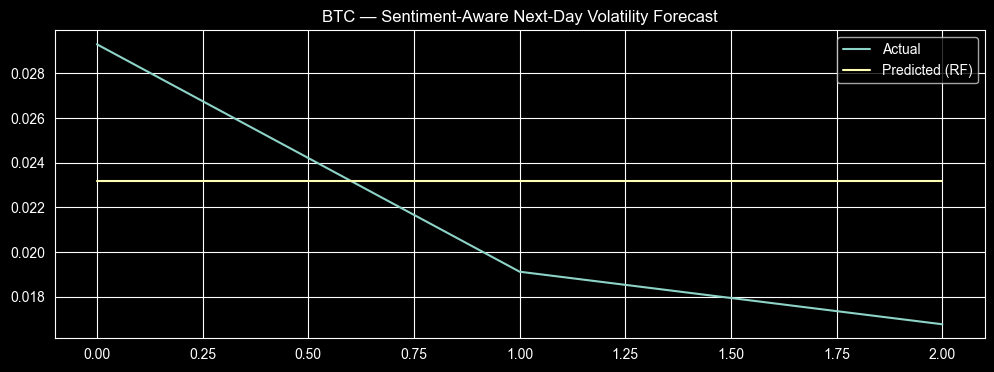

In [10]:
plt.figure(figsize=(12,4))
plt.plot(actual_vol.values[:100], label="Actual")
plt.plot(pred_vol[:100], label="Predicted (RF)")
plt.title("BTC — Sentiment-Aware Next-Day Volatility Forecast")
plt.legend()
plt.show()